# GPU Performance

We wanted to see how well Whisper performed with our selected options and the large model with the GPU active and with it off. So we used the results from the RDS GPU Workstation with the GPU activated, and with it explicitly turned off.

In [7]:
import pandas

rds = pandas.read_csv('../docs/output-2024-04-11/report-whisper.csv')
rds = rds[rds['options'] == "{'model_name': 'large', 'beam_size': 5, 'patience': 1.0, 'condition_on_previous_text': False, 'best_of': 5}"]
rds = rds[['druid', 'runtime']]
rds.columns = ['druid', 'runtime_gpu']
rds

,druid,runtime_gpu
8,bb158br2509,219.484938
54,bg405cn7261,88.899626
100,bw689yg2740,585.138051
160,fh290wd1772,15.008326
208,gj097zq7635,364.681268
268,gk220dt2833,50.418620
302,gn213vd3845,36.881981
336,kp010zv7055,51.779526
384,qf378nj5000,294.352984
456,tc482fh1865,30.908619


In [8]:
ec2 = pandas.read_csv('../docs/output-2024-04-11/report-whisper-no-gpu.csv')
ec2 = ec2[['druid', 'runtime']]
ec2.columns = ['druid', 'runtime_no_gpu']
ec2

,druid,runtime_no_gpu
0,bb158br2509,3751.747041
1,bg405cn7261,1418.956508
2,br525sp8033,513.360833
3,bw689yg2740,8025.186742
4,fh290wd1772,185.653383
5,gj097zq7635,4751.485338
6,gk220dt2833,617.842409
7,gn213vd3845,459.003698
8,kp010zv7055,706.003798
9,qf378nj5000,3769.095157


In [9]:
results = rds.join(ec2.set_index('druid'), on='druid')
results

,druid,runtime_gpu,runtime_no_gpu
8,bb158br2509,219.484938,3751.747041
54,bg405cn7261,88.899626,1418.956508
100,bw689yg2740,585.138051,8025.186742
160,fh290wd1772,15.008326,185.653383
208,gj097zq7635,364.681268,4751.485338
268,gk220dt2833,50.418620,617.842409
302,gn213vd3845,36.881981,459.003698
336,kp010zv7055,51.779526,706.003798
384,qf378nj5000,294.352984,3769.095157
456,tc482fh1865,30.908619,389.315036


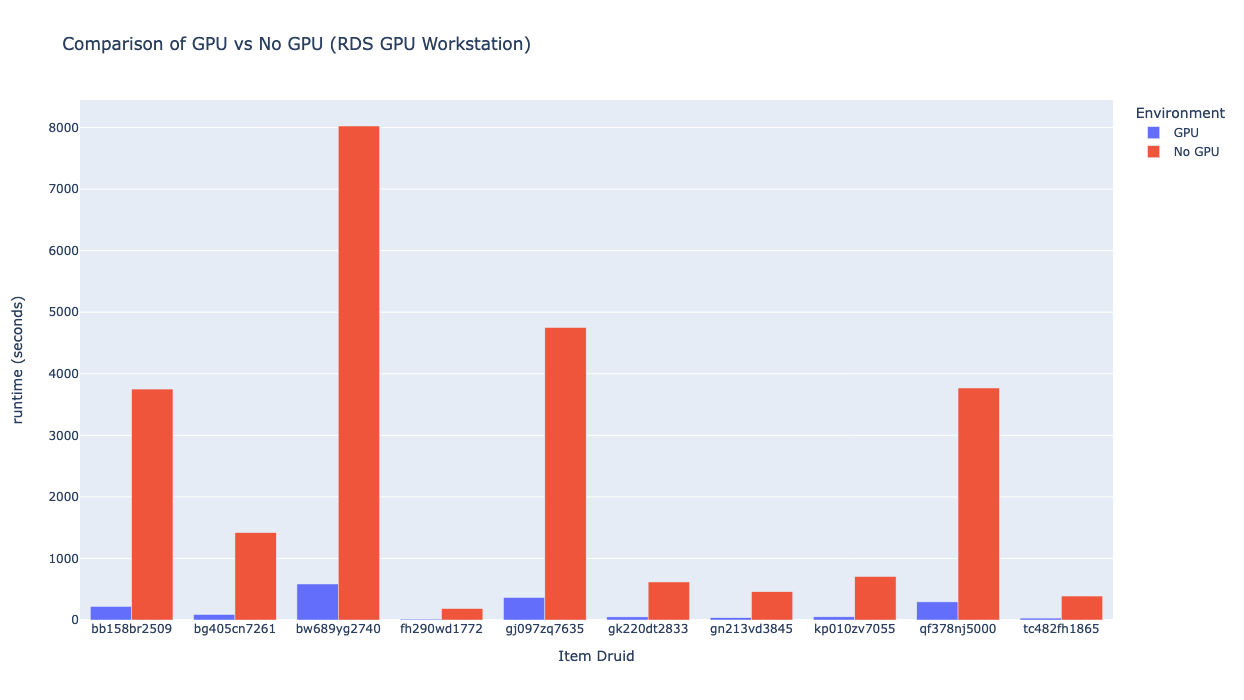

In [13]:
from plotly import express as xp

fig = xp.bar(
    results.set_index('druid'),
    barmode='group',
    labels={
        'value': 'runtime (seconds)',
        'druid': 'Item Druid',
        'variable': 'Environment'
    },
    title='Comparison of GPU vs No GPU (RDS GPU Workstation)',
    height=700
)
fig.data[0].name = 'GPU'
fig.data[1].name = 'No GPU'
fig

I did notice that when it didn't have access to a GPU it seemed to actively use as many CPUs as it could. So these results would be even worse on a machine that didn't have 32 cores.

## Processing Rate


In [15]:
sdr = pandas.read_csv('../sdr-data.csv')
sdr = sdr[['Druid', 'Duration']]
sdr.columns = ['druid', 'duration']
sdr

,druid,duration
0,bb158br2509,1842
1,bg405cn7261,655
2,bh446wm7842,9642
3,br525sp8033,471
4,bw689yg2740,5080
5,gj097zq7635,2849
6,tc482fh1865,246
7,gk220dt2833,4463
8,qf378nj5000,2294
9,fh290wd1772,133


In [16]:
results = results.join(sdr.set_index('druid'), on='druid')
results

,druid,runtime_gpu,runtime_no_gpu,duration
8,bb158br2509,219.484938,3751.747041,1842
54,bg405cn7261,88.899626,1418.956508,655
100,bw689yg2740,585.138051,8025.186742,5080
160,fh290wd1772,15.008326,185.653383,133
208,gj097zq7635,364.681268,4751.485338,2849
268,gk220dt2833,50.418620,617.842409,4463
302,gn213vd3845,36.881981,459.003698,371
336,kp010zv7055,51.779526,706.003798,1897
384,qf378nj5000,294.352984,3769.095157,2294
456,tc482fh1865,30.908619,389.315036,246


In [17]:
results['gpu_processing_rate'] = results['duration'] / results['runtime_gpu']
results['no_gpu_processing_rate'] = results['duration'] / results['runtime_no_gpu']
results

,druid,runtime_gpu,runtime_no_gpu,duration,gpu_processing_rate,no_gpu_processing_rate
8,bb158br2509,219.484938,3751.747041,1842,8.392375,0.490971
54,bg405cn7261,88.899626,1418.956508,655,7.367860,0.461607
100,bw689yg2740,585.138051,8025.186742,5080,8.681712,0.633007
160,fh290wd1772,15.008326,185.653383,133,8.861748,0.716389
208,gj097zq7635,364.681268,4751.485338,2849,7.812301,0.599602
268,gk220dt2833,50.418620,617.842409,4463,88.518884,7.223525
302,gn213vd3845,36.881981,459.003698,371,10.059113,0.808272
336,kp010zv7055,51.779526,706.003798,1897,36.636102,2.686954
384,qf378nj5000,294.352984,3769.095157,2294,7.793364,0.608634
456,tc482fh1865,30.908619,389.315036,246,7.958945,0.631879


In [18]:
results.gpu_processing_rate.mean()

19.20824050272715

In [19]:
results.no_gpu_processing_rate.mean()

1.4860840668170598

In [20]:
19.208 / 1.486

12.925975773889636